In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from importlib import reload
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import glob
from shutil import copyfile
from keras.models import load_model
from keras import optimizers

In [2]:
img_shape = (224, 224, 3)
resnet_model = ResNet50(include_top=False, input_shape=img_shape) #Exclude the top Layer by adding include_top=False

In [3]:
classes = [
    'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1',
    'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3',
    'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3',
    'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6',
    'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2',
    'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4',
    'Class11.5', 'Class11.6'
] #37 vectors of Galaxy Zoo divided into 11 classes based on the 11 different questions and their responses


def append_ext(fn):
    '''
    This function is used to take the GalaxyID from the CSV and append .jpg to it in order to denote the image names. 
    '''
    return fn + ".jpg"

traindf = pd.read_csv(os.path.join(r"D:\OneDrive\Major Project\Code\Galaxy_Morphology\Data\GalaxyZoo1\train", 'training_solutions_rev1.csv')) #Read the Data Frame using pandas

traindf["id"] = traindf['GalaxyID'].astype(str).apply(append_ext) #Create a new column in the Data Frame called 'id' which has the image names.
traindf

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6,id
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.000000,0.0,0.325512,100008.jpg
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.0,0.000000,100023.jpg
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,100053.jpg
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.000000,0.0,0.000000,100078.jpg
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,100090.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61573,999948,0.510379,0.489621,0.000000,0.059207,0.430414,0.000000,0.430414,0.226257,0.204157,...,0.226257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.226257,999948.jpg
61574,999950,0.901216,0.098784,0.000000,0.000000,0.098784,0.000000,0.098784,0.000000,0.098784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,999950.jpg
61575,999958,0.202841,0.777376,0.019783,0.116962,0.660414,0.067245,0.593168,0.140022,0.520391,...,0.000000,0.090673,0.049349,0.000000,0.067726,0.000000,0.000000,0.0,0.072296,999958.jpg
61576,999964,0.091000,0.909000,0.000000,0.045450,0.863550,0.022452,0.841098,0.795330,0.068220,...,0.068398,0.318132,0.408799,0.227464,0.408799,0.090668,0.023065,0.0,0.045334,999964.jpg


In [4]:
def convert_rgb_to_grayscale(image):
    return tf.image.rgb_to_grayscale(image)

datagenerator = ImageDataGenerator(
    fill_mode='nearest',
    cval=0,
    rescale=1/255,
    preprocessing_function=convert_rgb_to_grayscale,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.02)

train_generator = datagenerator.flow_from_dataframe(
    dataframe=traindf,
    directory="D:/OneDrive/Major Project/Code/Galaxy_Morphology/Data/GalaxyZoo1/train/images_training_rev1",
    x_col="id",
    y_col=classes,
    subset="training",
    batch_size=16,
    seed=123,
    shuffle=True,
    class_mode="raw",
    target_size=(224, 224))

validation_generator = datagenerator.flow_from_dataframe(
    dataframe=traindf,
    directory="D:/OneDrive/Major Project/Code/Galaxy_Morphology/Data/GalaxyZoo1/train/images_training_rev1",
    x_col="id",
    y_col=classes,
    subset="validation",
    batch_size=16,
    seed=123,
    shuffle=True,
    class_mode="raw",
    target_size=(224, 224))

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

Found 60347 validated image filenames.
Found 1231 validated image filenames.


In [5]:
# Flatten output of last layer before adding output layer (Dense layer)
x = Flatten()(resnet_model.output)

# Add output layer (number of outputs = 37)
x = Dense(len(classes), activation='sigmoid')(x)

# Load the modified model
model = Model(inputs=resnet_model.input, outputs=x)

In [6]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [7]:
for layer in model.layers:
    layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=5e-4)

model.compile(optimizer, loss='mse', metrics=["accuracy"])

In [8]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))


early_stopping = EarlyStopping(
    monitor='val_loss', patience=4, verbose=1, mode='auto')

history = LossHistory()

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(
    filepath='../../../Data/GalaxyZoo1/weights/graynofreezeweights.hdf5', verbose=2, save_best_only=True)

In [9]:
hist = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=30,
    callbacks=[history, checkpointer, early_stopping])

Epoch 1/30
3771/3771 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.5953
Epoch 1: val_loss improved from inf to 0.05840, saving model to ../../../Data/GalaxyZoo1/weights\graynofreezeweights.hdf5
3771/3771 [==============================] - 3217s 848ms/step - loss: 0.0593 - accuracy: 0.5953 - val_loss: 0.0584 - val_accuracy: 0.6308
Epoch 2/30
3771/3771 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.5954
Epoch 2: val_loss improved from 0.05840 to 0.05830, saving model to ../../../Data/GalaxyZoo1/weights\graynofreezeweights.hdf5
3771/3771 [==============================] - 1753s 465ms/step - loss: 0.0592 - accuracy: 0.5954 - val_loss: 0.0583 - val_accuracy: 0.6308
Epoch 3/30
3771/3771 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.5954
Epoch 3: val_loss did not improve from 0.05830
3771/3771 [==============================] - 2291s 607ms/step - loss: 0.0592 - accuracy: 0.5954 - val_loss: 0.0584 - val_accuracy: 0.62

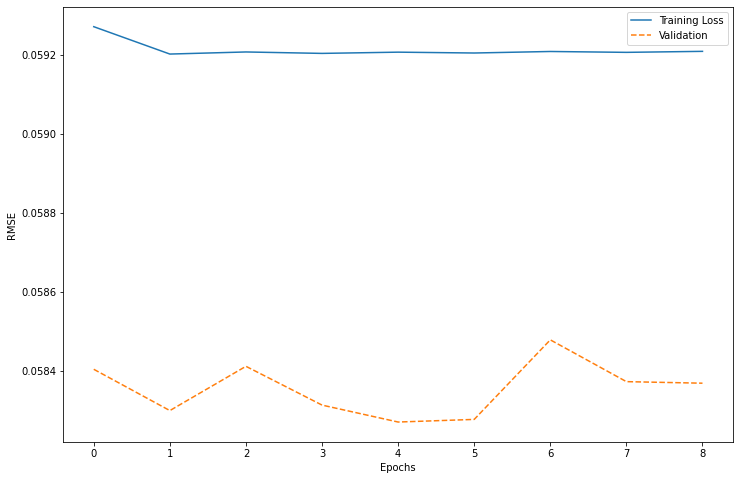

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(hist.epoch, hist.history['loss'], label='Training Loss')
plt.plot(
    hist.epoch, hist.history['val_loss'], label='Validation', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()